<center>
    <img src="http://sct.inf.utfsm.cl/wp-content/uploads/2020/04/logo_di.png" style="width:60%">
    <h1> INF285 - Computación Científica </h1>
    <h2> Trabajo 2</h2>
    <h2> [S]cientific [C]omputing [T]eam </a> </h2>
    <h2> Version: 1.00</h2>
</center>

# Contexto

Los patrones de fractura aparecen en distintos campos desde la geología a la ciencia de materiales. A veces el foco está puesto en la forma de la fractura misma, pero otros investigadores están interesados en indicadores que permiten mostrar el comportamiento del patrón. Por ejemplo, la distribución de las áreas de cada celda, la distribución de los perímetros de cada celda, o la densidad del patrón, la cual consiste en conocer el porcentaje de "fracturas" presentes en el patrón versus el dominio. Si un patrón de fractura lo consideramos como una imagen, esta puede ser leída como una matriz binaria, por lo tanto, su densidad será la razón de pixeles negros sobre el dominio total.

A continuación se entrega una serie de funciones y variables a utilizar en esta tarea.

## Librerías, variables y funciones predefinidas (NO MODIFICAR)

In [ ]:
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
SIZE=125
M=100

#loading mu vector
mu = np.load("mu.npy")

#loading densities
den = np.load("densities.npy")

In [ ]:
def readImage(filename):
  """
  Parameters
  ----------
  filename:  str
             name of the file to read.
  Returns
  ----------
  img:       ndarray
             array with dimension SIZE x SIZE.
  """
  img = mpimg.imread(filename)
  img = img[:,:,0]
  return img

def binarize(img):
  """
  Parameters
  ----------
  img:       ndarray
             array with dimension SIZE x SIZE.

  Returns
  -------
  img_bin:   ndarray
             array with dimension SIZE x SIZE where
             0's are black pixels and 1's white pixels.
  """
  min_,max_ = np.min(img),np.max(img)
  mean = .5*(min_ + max_)
  img_bin = np.where(img < mean,0.,1.)
  return img_bin

def showImage(img):
  """
  Parameters
  ----------
  img: ndarray
       array with dimension SIZE x SIZE where
       0's are black pixels and 1's white pixels.
  """
  plt.imshow(img,cmap=plt.get_cmap("gray"))
  plt.show()

def density(img):
  """
  Parameters
  ----------
  img: ndarray
        array with dimension SIZE x SIZE where
        0's are black pixels and 1's white pixels.

  Returns
  ----------
  img: double
        percentage of black pixels over the total.
  """
  nx,ny = img.shape
  img = binarize(img)
  return 1. - np.sum(img)/(nx*ny)

def vectorToImage(vec):
  """
  Parameters
  ----------
  vec: ndarray
       1D array with dimension SIZE^2 where
       0's are black pixels and 1's white pixels.

  Returns
  -------
  img: ndarray
       array with dimension SIZE x SIZE where
       0's are black pixels and 1's white pixels.
  """
  img = np.reshape(vec,(SIZE,SIZE))
  return img

Usted cuenta con una carpeta de patrones de fractura que lamentablemente están con ruido. La carpeta se denomina "pattern". Además cuenta también con la media $\mu$ de los datos originales (patrones sin ruido) y las densidades de cada imagen sin ruido. El objetivo de la tarea es reducir tal ruido lo que más se pueda. A continuación se muestra un patrón con ruido.

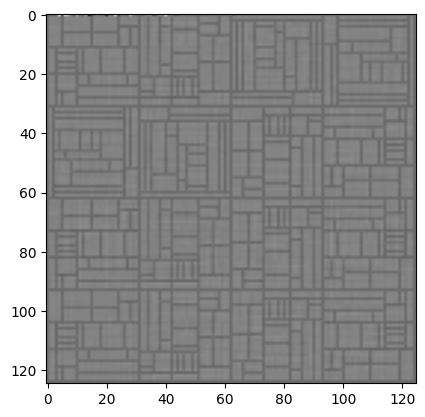

In [ ]:
img = readImage("pattern/img-0.png")
showImage(img)

Una solución posible es *binarizar* directamente la imagen como se muestra a continuación:

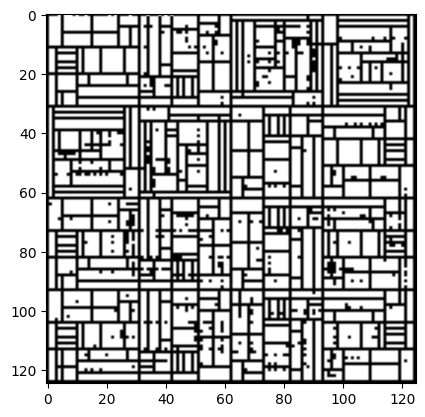

In [ ]:
img = binarize(img)
showImage(img)

El problema es que aún queda ruido, por lo tanto se busca utilizar PCA para poder reducirlo de mejor manera.

### Pregunta 1: construcción de la matriz X (20 puntos)

Construya la función $\verb|buildMatrix|$, la cual debe leer las imágenes ruidosas y guardar su información en la matriz X.

*hint: the function $\verb|img.flatten|$ may be useful to compact the information of a pattern.*

In [ ]:
def buildMatrix(M,SIZE):
  """
  Parameters
  ----------
  M    :int
        number of noisy images to read.
  SIZE :int
        SIZE x SIZE is the dimension of each noisy image.

  Returns
  -------
  X   : ndarray
        array with dimension M x SIZE^2 with data as row vectors.
  """
  # No modificar
  path = "pattern/"

  # Escriba su código aquí
  # -----------------------------------
  X = np.zeros((M,SIZE**2))
  for i in np.arange(M):
    filename = path + "img-{}.png".format(i)
    img = readImage(filename)
    img = img.flatten()
    X[i,:] = img
  # -----------------------------------
  return X
X = buildMatrix(M,SIZE)

### Pregunta 2: PCA (20 puntos)

Construya la función $\verb|PCA|$, la cual recibe la matriz $X$ con la información de las imágenes ruidosas y la media por columna de las imágenes originales. Se debe aplicar SVD correctamente, y retornar la matriz resultante $Vh$ así como también los coeficientes proyectados $Y$.

In [ ]:
def PCA(X,mu):
  """
  Parameters
  ----------
  X  :ndarray
      array with data of the noisy images.
  mu :ndarray
      array of mean per column of original data.

  Returns
  ----------
  Vh       :ndarray
            array of the principal components.
  Y        :ndarray
            array of projected coefficients.
  """
  # Escriba su código aquí
  # -----------------------------------
  Z = X - mu
  _,_,Vh = np.linalg.svd(Z,full_matrices=False)
  Y = Z @ Vh.T
  # -----------------------------------
  return Vh,Y

### Pregunta 3: Reconstrucción (20 puntos)

Construya la función $\verb|reconstruccion|$, la cual a partir de la información obtenida de la función $\verb|PCA|$ debe obtener las imágenes reconstruidas con $k$ componentes principales.

In [ ]:
def reconstruccion(Vh,Y,mu,k):
  """
  Parameters
  ----------
  Vh  :ndarray
       array of the principal components.
  Y   :ndarray
       array of projected coefficients.
  mu  :double
       1D array of averages per column of original data.
  k   :int
       number of principal components to use.

  Returns
  -------
  Xr  :ndarray
       array with data of the reconstructed images with k principal components.
  """
  # Escriba su código aquí
  # -----------------------------------
  Zr = Y[:,:k] @ Vh[:k,:]
  Xr = Zr + mu
  # -----------------------------------
  return Xr

### Pregunta 4: Mejor k (30 puntos)

Construya la función $\verb|mejorK|$, la cual determine la cantidad de $k$ componentes principales que se deben utilizar para reconstruir la $i$-ésima imagen, de tal manera que su densidad sea lo más cercano posible al valor de la $i$-ésima densidad teórica conocida almacenada en la $i$-ésima componente de la variable $\verb|den|$. Evalúe esta función con $i = 0$.

In [ ]:
def mejorK(i,Vh,Y,mu,den):
  """
  Parameters
  ----------
  i   :int
       i-th image to be denoised.
  Vh  :ndarray
       array of the principal components.
  Y   :ndarray
       array of projected coefficients.
  mu  :double
       1D array of averages per column of original data.
  den :ndarray
       1D array of target densities.

  Returns
  -------
  kb  :int
       best number of principal components.
  Xd  :ndarray
       array with data of the denoised image.
  """
  # Escriba su código aquí
  # -----------------------------------
  den_i = den[i]
  error = np.zeros(M)
  for k in np.arange(M):
    Xr = reconstruccion(Vh,Y,mu,k)
    Xr_i = vectorToImage(Xr[i,:])
    error[k] = np.abs(den_i - density(Xr_i))
  kb = np.argmin(error)
  Xr = reconstruccion(Vh,Y,mu,kb)
  Xd = vectorToImage(Xr[i,:])
  # -----------------------------------
  return kb,Xd

**¡Ya ha llegado al final del trabajo número 2! Ahora debe enviarla antes de las 18:00 hrs.**